In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import urllib.request as req
import time
import folium
import geopandas as gpd
import html5lib as html
pd.options.display.float_format = '{:.5f}'.format

In [2]:
# 한글 폰트 문제 해결 
# matplotlib은 한글 폰트를 지원하지 않음
# os정보
import platform

# font_manager : 폰트 관리 모듈
# rc : 폰트 변경 모듈
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# unicode 설정
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic') # os가 macos
elif platform.system() == 'Windows':
    path = 'c:/Windows/Fonts/malgun.ttf' # os가 windows
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print("Unknown System")

### 제주도 단기체류 방문 (관광) 외국인 유동인구 추이

In [3]:
check = pd.read_csv("../JejuData/제주도 단기체류 방문 외국인 유동인구 추이.csv",encoding='euc-kr')
check['nationality'].value_counts()

중국       46116
미국       43398
기타       43221
태국       36034
일본       33282
인도네시아    32684
말레이시아    31643
홍콩       24687
싱가포르     20991
베트남      18767
Name: nationality, dtype: int64

In [5]:
foreigner = pd.read_csv("../JejuData/제주도 단기체류 방문 외국인 유동인구 추이.csv",encoding='euc-kr')

In [6]:
foreigner

,base_date,nationality,time_range,emd_name,visit_population_count
0,201801,기타,1-2시,서귀포시 남원읍,401.92000
1,201801,기타,1-2시,서귀포시 서홍동,42.31000
2,201801,기타,1-2시,서귀포시 성산읍,317.31000
3,201801,기타,1-2시,서귀포시 안덕면,423.08000
4,201801,기타,1-2시,서귀포시 예래동,84.62000
...,...,...,...,...,...
330818,202209,홍콩,23-24시,제주시 조천읍,16.45000
330819,202209,홍콩,23-24시,제주시 추자면,27.00000
330820,202209,홍콩,23-24시,제주시 한경면,9.39000
330821,202209,홍콩,23-24시,제주시 한림읍,6.40000


In [3]:
foreigner.columns = ['년월','국적','시간대','읍면동명','방문객수']

### foreigner 년월 jeju_sales와 통일 (년월 사이에 - 추가)

In [6]:
foreigner['년월'] = foreigner['년월'].astype('str')

In [7]:
foreigner['년월'] = foreigner['년월'].str[0:4]+'-'+foreigner['년월'].str[4:6]

### foreigner 읍면동명 시도명과 읍면동명으로 분리

In [4]:
foreigner

,년월,국적,시간대,읍면동명,방문객수
0,201801,기타,1-2시,서귀포시 남원읍,401.92000
1,201801,기타,1-2시,서귀포시 서홍동,42.31000
2,201801,기타,1-2시,서귀포시 성산읍,317.31000
3,201801,기타,1-2시,서귀포시 안덕면,423.08000
4,201801,기타,1-2시,서귀포시 예래동,84.62000
...,...,...,...,...,...
330818,202209,홍콩,23-24시,제주시 조천읍,16.45000
330819,202209,홍콩,23-24시,제주시 추자면,27.00000
330820,202209,홍콩,23-24시,제주시 한경면,9.39000
330821,202209,홍콩,23-24시,제주시 한림읍,6.40000


In [9]:
foreigner.loc[foreigner['읍면동명'].str.contains('서귀포시'), '시도명'] = '서귀포시'
foreigner.loc[foreigner['읍면동명'].str.contains('제주시'), '시도명'] = '제주시'
foreigner['읍면동명'] = foreigner['읍면동명'].str.replace("서귀포시 ","")
foreigner['읍면동명'] = foreigner['읍면동명'].str.replace("제주시 ","")

# 읍면동명 숫자 문자로 변경
# foreigner['읍면동명'] = foreigner['읍면동명'].str.replace("1","일")
# foreigner['읍면동명'] = foreigner['읍면동명'].str.replace("2","이")
# 행정동은 숫자, 법정동은 문자로 되어있음

In [10]:
foreigner

,년월,국적,시간대,읍면동명,방문객수,시도명
0,2018-01,기타,1-2시,남원읍,401.92000,서귀포시
1,2018-01,기타,1-2시,서홍동,42.31000,서귀포시
2,2018-01,기타,1-2시,성산읍,317.31000,서귀포시
3,2018-01,기타,1-2시,안덕면,423.08000,서귀포시
4,2018-01,기타,1-2시,예래동,84.62000,서귀포시
...,...,...,...,...,...,...
330818,2022-09,홍콩,23-24시,조천읍,16.45000,제주시
330819,2022-09,홍콩,23-24시,추자면,27.00000,제주시
330820,2022-09,홍콩,23-24시,한경면,9.39000,제주시
330821,2022-09,홍콩,23-24시,한림읍,6.40000,제주시


In [11]:
pd.read_csv("../JejuData/제주도 단기체류 방문 외국인 유동인구 추이.csv",encoding='euc-kr')['nationality'].unique()
# ['기타', '말레이시아', '미국', '인도네시아', '일본', '중국', '태국', '베트남', '싱가포르','홍콩']

array(['기타', '말레이시아', '미국', '인도네시아', '일본', '중국', '태국', '베트남', '싱가포르',
       '홍콩'], dtype=object)

### 2020년 12월까지 자르기

In [12]:
foreigner_loc = foreigner.iloc[:171402,:]

## Sales 데이터셋 2018년 1월~2021년 5월 => 2017년 1월~2020년 12월까지로 변경

> Sales dataset (법정동)

In [13]:
# sales_loc_type = pd.read_csv("../JejuData/sales_loc_type2.csv")
# sales_loc_type

> Sales Dataset (행정동)

In [16]:
from glob import glob

file_names = glob("../JejuData/jeju_sales/*.csv")
sales = pd.DataFrame()
for file_name in file_names:
    temp = pd.read_csv(file_name, encoding='euc-kr')
    sales = pd.concat([sales, temp])
sales = sales.sort_values(by=['년월','읍면동명'],ascending=True)

In [18]:
sales['업종명'].unique()

array(['비알콜 음료점업', '기타 주점업', '기타음식료품위주종합소매업', '과실 및 채소 소매업',
       '관광 민예품 및 선물용품 소매업', '기타 외국식 음식점업', '면세점', '빵 및 과자류 소매업',
       '수산물 소매업', '슈퍼마켓', '스포츠 및 레크레이션 용품 임대업', '여관업', '욕탕업', '서양식 음식점업',
       '화장품 및 방향제 소매업', '호텔업', '한식 음식점업', '일식 음식점업',
       '피자, 햄버거, 샌드위치 및 유사 음식점업', '체인화 편의점', '차량용 주유소 운영업', '차량용 가스 충전업',
       '중식 음식점업', '자동차 임대업', '일반유흥 주점업', '육류 소매업', '그외 기타 스포츠시설 운영업',
       '골프장 운영업', '그외 기타 종합 소매업', '여행사업', '전시 및 행사 대행업', '휴양콘도 운영업',
       '건강보조식품 소매업', '그외 기타 분류안된 오락관련 서비스업', '마사지업', '기타 대형 종합 소매업',
       '내항 여객 운송업', '기타 수상오락 서비스업', '정기 항공 운송업', '버스 운송업', '택시 운송업'],
      dtype=object)

In [15]:
len(sales['읍면동명'].unique())

43

In [16]:
len(foreigner_loc['읍면동명'].unique())

43

> 외국인 유동인구 & 카드 매출액 변화 데이터 읍면동 일치함 확인

In [17]:
sales

,년월,시도명,읍면동명,업종명,성별,이용자수,이용금액,거주인구,근무인구,방문인구,데이터기준일자
1426,2018-01-01,제주시,건입동,비알콜 음료점업,남성,259,2981280,2447350.78700,442110.29000,2758414.76300,2020-12-15
1443,2018-01-01,제주시,건입동,기타 주점업,남성,99,21120000,2447350.78700,442110.29000,2758414.76300,2020-12-15
1450,2018-01-01,제주시,건입동,기타음식료품위주종합소매업,남성,26,3434950,2447350.78700,442110.29000,2758414.76300,2020-12-15
1455,2018-01-01,제주시,건입동,과실 및 채소 소매업,남성,42,4959500,2447350.78700,442110.29000,2758414.76300,2020-12-15
1456,2018-01-01,제주시,건입동,관광 민예품 및 선물용품 소매업,남성,67,1565050,2447350.78700,442110.29000,2758414.76300,2020-12-15
...,...,...,...,...,...,...,...,...,...,...,...
26514,2020-12,서귀포시,효돈동,중식 음식점업,남성,391,8687500,1535266.85200,95602.03900,631567.06900,2021-07-26
26515,2020-12,서귀포시,효돈동,중식 음식점업,여성,160,4345000,1447374.27000,101519.96600,553046.89000,2021-07-26
26516,2020-12,서귀포시,효돈동,차량용 가스 충전업,남성,19,962280,1535266.85200,95602.03900,631567.06900,2021-07-26
26517,2020-12,서귀포시,효돈동,차량용 가스 충전업,여성,17,884910,1447374.27000,101519.96600,553046.89000,2021-07-26


### sales 년월 컬럼 수정 (일자 제거)

In [18]:
sales['년월'].unique()

array(['2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
       '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
       '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
       '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
       '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
       '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
       '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01', '2020-05',
       '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11',
       '2020-12'], dtype=object)

In [19]:
sales['년월'] = sales['년월'].str[0:7]

In [20]:
sales.reset_index(drop=True, inplace=True)

In [21]:
sales[sales['년월'].str.contains('2017')].head(30)

,년월,시도명,읍면동명,업종명,성별,이용자수,이용금액,거주인구,근무인구,방문인구,데이터기준일자


### 근무인구, 데이터기준일자 제거

In [22]:
sales.drop(columns=['근무인구','데이터기준일자'],inplace=True)

### Sales 2018년 1월~2020년 12월까지 cut (foreigner에 맞추기)

In [23]:
sales[sales['년월']=='2018-01']

,년월,시도명,읍면동명,업종명,성별,이용자수,이용금액,거주인구,방문인구
0,2018-01,제주시,건입동,비알콜 음료점업,남성,259,2981280,2447350.78700,2758414.76300
1,2018-01,제주시,건입동,기타 주점업,남성,99,21120000,2447350.78700,2758414.76300
2,2018-01,제주시,건입동,기타음식료품위주종합소매업,남성,26,3434950,2447350.78700,2758414.76300
3,2018-01,제주시,건입동,과실 및 채소 소매업,남성,42,4959500,2447350.78700,2758414.76300
4,2018-01,제주시,건입동,관광 민예품 및 선물용품 소매업,남성,67,1565050,2447350.78700,2758414.76300
...,...,...,...,...,...,...,...,...,...
2241,2018-01,서귀포시,효돈동,과실 및 채소 소매업,남성,368,17836300,1458593.44400,633029.08900
2242,2018-01,서귀포시,효돈동,그외 기타 종합 소매업,남성,1,1000000,1458593.44400,633029.08900
2243,2018-01,서귀포시,효돈동,기타음식료품위주종합소매업,남성,737,24632980,1458593.44400,633029.08900
2244,2018-01,서귀포시,효돈동,비알콜 음료점업,남성,91,1164120,1458593.44400,633029.08900


In [24]:
sales_loc_type = sales.iloc[26968:,:]

## sales_loc_type

In [25]:
sales_loc_type

,년월,시도명,읍면동명,업종명,성별,이용자수,이용금액,거주인구,방문인구
26968,2018-12,서귀포시,표선면,스포츠 및 레크레이션 용품 임대업,여성,250,6370150,2849679.72500,1768093.94800
26969,2018-12,서귀포시,표선면,수산물 소매업,여성,242,17058500,2849679.72500,1768093.94800
26970,2018-12,서귀포시,표선면,서양식 음식점업,여성,508,9231710,2849679.72500,1768093.94800
26971,2018-12,서귀포시,표선면,빵 및 과자류 소매업,여성,524,7714790,2849679.72500,1768093.94800
26972,2018-12,서귀포시,표선면,비알콜 음료점업,여성,282,3436000,2849679.72500,1768093.94800
...,...,...,...,...,...,...,...,...,...
81532,2020-12,서귀포시,효돈동,중식 음식점업,남성,391,8687500,1535266.85200,631567.06900
81533,2020-12,서귀포시,효돈동,중식 음식점업,여성,160,4345000,1447374.27000,553046.89000
81534,2020-12,서귀포시,효돈동,차량용 가스 충전업,남성,19,962280,1535266.85200,631567.06900
81535,2020-12,서귀포시,효돈동,차량용 가스 충전업,여성,17,884910,1447374.27000,553046.89000


### 년 컬럼 추가

In [26]:
df_pop = sales_loc_type.copy()

In [27]:
df_pop['년'] = sales_loc_type['년월'].str[0:4]

In [28]:
df_pop

,년월,시도명,읍면동명,업종명,성별,이용자수,이용금액,거주인구,방문인구,년
26968,2018-12,서귀포시,표선면,스포츠 및 레크레이션 용품 임대업,여성,250,6370150,2849679.72500,1768093.94800,2018
26969,2018-12,서귀포시,표선면,수산물 소매업,여성,242,17058500,2849679.72500,1768093.94800,2018
26970,2018-12,서귀포시,표선면,서양식 음식점업,여성,508,9231710,2849679.72500,1768093.94800,2018
26971,2018-12,서귀포시,표선면,빵 및 과자류 소매업,여성,524,7714790,2849679.72500,1768093.94800,2018
26972,2018-12,서귀포시,표선면,비알콜 음료점업,여성,282,3436000,2849679.72500,1768093.94800,2018
...,...,...,...,...,...,...,...,...,...,...
81532,2020-12,서귀포시,효돈동,중식 음식점업,남성,391,8687500,1535266.85200,631567.06900,2020
81533,2020-12,서귀포시,효돈동,중식 음식점업,여성,160,4345000,1447374.27000,553046.89000,2020
81534,2020-12,서귀포시,효돈동,차량용 가스 충전업,남성,19,962280,1535266.85200,631567.06900,2020
81535,2020-12,서귀포시,효돈동,차량용 가스 충전업,여성,17,884910,1447374.27000,553046.89000,2020


In [29]:
df_pop.groupby(['년월','읍면동명','업종명','성별']).sum().head(10)

이용자수      이용금액          거주인구          방문인구
년월      읍면동명 업종명             성별                                            
2018-12 표선면  과실 및 채소 소매업     여성   519  75553100 2849679.72500 1768093.94800
             그외 기타 스포츠시설 운영업 여성    36   2229000 2849679.72500 1768093.94800
             그외 기타 종합 소매업    여성     6   1780000 2849679.72500 1768093.94800
             기타 외국식 음식점업     여성    17    418000 2849679.72500 1768093.94800
             기타 주점업          여성    21   3885000 2849679.72500 1768093.94800
             기타음식료품위주종합소매업   여성  2276  78724370 2849679.72500 1768093.94800
             비알콜 음료점업        여성   282   3436000 2849679.72500 1768093.94800
             빵 및 과자류 소매업     여성   524   7714790 2849679.72500 1768093.94800
             서양식 음식점업        여성   508   9231710 2849679.72500 1768093.94800
             수산물 소매업         여성   242  17058500 2849679.72500 1768093.94800

### 업종명 선정

In [30]:
business_list = ['서양식 음식점업','기타 외국식 음식점업','피자, 햄버거, 샌드위치 및 유사 음식점업','한식 음식점업', '일식 음식점업','중식 음식점업','비알콜 음료점업']

In [31]:
sales_restaurant = df_pop[df_pop['업종명'].isin(business_list)]

In [32]:
sales_restaurant.groupby(['년월','읍면동명','업종명','성별']).sum().head(30)

이용자수       이용금액          거주인구  \
년월      읍면동명 업종명                     성별                                  
2018-12 표선면  기타 외국식 음식점업             여성    17     418000 2849679.72500   
             비알콜 음료점업                여성   282    3436000 2849679.72500   
             서양식 음식점업                여성   508    9231710 2849679.72500   
             중식 음식점업                 여성   163    4297010 2849679.72500   
             피자, 햄버거, 샌드위치 및 유사 음식점업 여성   437    8374714 2849679.72500   
             한식 음식점업                 여성  3223  152258311 2849679.72500   
        한경면  비알콜 음료점업                남성    69    1138500 2121829.17700   
                                     여성    65    1093500 1924539.51900   
             서양식 음식점업                남성   739   16441650 2121829.17700   
                                     여성   933   20446500 1924539.51900   
             일식 음식점업                 남성   139    5968900 2121829.17700   
                                     여성    85    3533700 1924539.51900   
             중식 음식점업                 남성   429   10690300 2121829.17700   
                                     여성   166    4568500 1924539.51900   
             피자, 햄버거, 샌드위치 및 유사 음식점업 남성   110    5079500 2121829.17700   
                                     여성    97    3456500 1924539.51900   
             한식 음식점업                 남성  3147  126241500 2121829.17700   
                                     여성  1673   68177640 1924539.51900   
        한림읍  기타 외국식 음식점업             남성   296    6635000 6937616.00200   
                                     여성   137    4073228 5908012.60200   
             비알콜 음료점업                남성   464    5542520 6937616.00200   
                                     여성   512    5642110 5908012.60200   
             서양식 음식점업                남성  2268   48955970 6937616.00200   
                                     여성  2563   51832760 5908012.60200   
             일식 음식점업                 남성   454   39144000 6937616.00200   
                                     여성   285   21477400 5908012.60200   
             중식 음식점업                 남성   754   23390700 6937616.00200   
                                     여성   349   13298000 5908012.60200   
             피자, 햄버거, 샌드위치 및 유사 음식점업 남성   858   13392750 6937616.00200   
                                     여성   724   11686620 5908012.60200   

                                                 방문인구  
년월      읍면동명 업종명                     성별                
2018-12 표선면  기타 외국식 음식점업             여성 1768093.94800  
             비알콜 음료점업                여성 1768093.94800  
             서양식 음식점업                여성 1768093.94800  
             중식 음식점업                 여성 1768093.94800  
             피자, 햄버거, 샌드위치 및 유사 음식점업 여성 1768093.94800  
             한식 음식점업                 여성 1768093.94800  
        한경면  비알콜 음료점업                남성 1045558.75500  
                                     여성  854976.91900  
             서양식 음식점업                남성 1045558.75500  
                                     여성  854976.91900  
             일식 음식점업                 남성 1045558.75500  
                                     여성  854976.91900  
             중식 음식점업                 남성 1045558.75500  
                                     여성  854976.91900  
             피자, 햄버거, 샌드위치 및 유사 음식점업 남성 1045558.75500  
                                     여성  854976.91900  
             한식 음식점업                 남성 1045558.75500  
                                     여성  854976.91900  
        한림읍  기타 외국식 음식점업             남성 3091309.64000  
                                     여성 2235881.59200  
             비알콜 음료점업                남성 3091309.64000  
                                     여성 2235881.59200  
             서양식 음식점업                남성 3091309.64000  
                                     여성 2235881.59200  
             일식 음식점업                 남성 3091309.64000  
                                     여성 2235881.59200  
             중식 음식점업                 남성 3091309.64000  
                                     여성 2235881.

In [33]:
sales_restaurant['업종명'].unique()

array(['서양식 음식점업', '비알콜 음료점업', '기타 외국식 음식점업', '중식 음식점업',
       '피자, 햄버거, 샌드위치 및 유사 음식점업', '한식 음식점업', '일식 음식점업'], dtype=object)

> 외식업종만 추출 완료

### 업종명 개수 확인 (성별로 하나씩 있는지)

In [34]:
sales_restaurant.value_counts('성별')
# 남성: 10305
# 여성: 10292
sales_restaurant.value_counts('업종명')
# 한식 음식점업                    3094
# 중식 음식점업                    3076
# 서양식 음식점업                   3062
# 비알콜 음료점업                   3046
# 일식 음식점업                    2898
# 기타 외국식 음식점업                2766
# 피자, 햄버거, 샌드위치 및 유사 음식점업    2655

업종명
한식 음식점업                    2071
비알콜 음료점업                   2067
서양식 음식점업                   2063
중식 음식점업                    2053
일식 음식점업                    1947
기타 외국식 음식점업                1854
피자, 햄버거, 샌드위치 및 유사 음식점업    1783
dtype: int64

### 외국인 유동인구 중국 or 중국 외로 구분

In [35]:
foreigner_loc.loc[foreigner_loc['국적']!='중국','국적'] = '중국 외'

In [36]:
foreigner_loc['국적'].value_counts()
# 중국 외    146700
# 중국       24702

중국 외    146700
중국       24702
Name: 국적, dtype: int64

In [37]:
len(foreigner_loc)

171402

> 중국: 24702, 중국 외: 146700  
> total: 171402 

### 외국인 유동인구 월별로 더하기

In [38]:
foreigner_loc

,년월,국적,시간대,읍면동명,방문객수,시도명
0,2018-01,중국 외,1-2시,남원읍,401.92000,서귀포시
1,2018-01,중국 외,1-2시,서홍동,42.31000,서귀포시
2,2018-01,중국 외,1-2시,성산읍,317.31000,서귀포시
3,2018-01,중국 외,1-2시,안덕면,423.08000,서귀포시
4,2018-01,중국 외,1-2시,예래동,84.62000,서귀포시
...,...,...,...,...,...,...
171397,2020-12,중국 외,23-24시,조천읍,0.58000,제주시
171398,2020-12,중국 외,23-24시,추자면,0.96000,제주시
171399,2020-12,중국 외,23-24시,한경면,0.19000,제주시
171400,2020-12,중국 외,23-24시,한림읍,0.13000,제주시


In [39]:
foreigner_loc.drop(columns='시간대',inplace=True)

In [40]:
foreigner_loc

,년월,국적,읍면동명,방문객수,시도명
0,2018-01,중국 외,남원읍,401.92000,서귀포시
1,2018-01,중국 외,서홍동,42.31000,서귀포시
2,2018-01,중국 외,성산읍,317.31000,서귀포시
3,2018-01,중국 외,안덕면,423.08000,서귀포시
4,2018-01,중국 외,예래동,84.62000,서귀포시
...,...,...,...,...,...
171397,2020-12,중국 외,조천읍,0.58000,제주시
171398,2020-12,중국 외,추자면,0.96000,제주시
171399,2020-12,중국 외,한경면,0.19000,제주시
171400,2020-12,중국 외,한림읍,0.13000,제주시


In [41]:
floating_foreigner = foreigner_loc.copy()

### floating_foreigner 정제
1. 중국 이외 국가 (일본, 동남아, 기타)가 단순히 중국 외로 변경되어있는 상태이므로 우선 분리 후 sum으로 합치기    
2. 중국과 중국 외 merge

In [42]:
floating_other = floating_foreigner[floating_foreigner['국적']=='중국 외'].groupby(['년월','국적','읍면동명','시도명']).sum().reset_index()

In [43]:
floating_other['년월'].value_counts()

2018-01    43
2018-02    43
2019-09    43
2019-10    43
2019-11    43
2019-12    43
2020-01    43
2020-02    43
2020-03    43
2020-04    43
2020-05    43
2020-06    43
2020-07    43
2020-08    43
2020-09    43
2020-10    43
2020-11    43
2019-08    43
2019-07    43
2019-06    43
2018-09    43
2018-03    43
2018-04    43
2018-05    43
2018-06    43
2018-07    43
2018-08    43
2018-10    43
2019-05    43
2018-11    43
2018-12    43
2019-01    43
2019-02    43
2019-03    43
2019-04    43
2020-12    43
Name: 년월, dtype: int64

In [44]:
floating_other
# 146700 -> 1548 samples

,년월,국적,읍면동명,시도명,방문객수
0,2018-01,중국 외,건입동,제주시,32542.06000
1,2018-01,중국 외,구좌읍,제주시,14845.87000
2,2018-01,중국 외,남원읍,서귀포시,22754.32000
3,2018-01,중국 외,노형동,제주시,31173.26000
4,2018-01,중국 외,대륜동,서귀포시,12868.88000
...,...,...,...,...,...
1543,2020-12,중국 외,표선면,서귀포시,2106.80000
1544,2020-12,중국 외,한경면,제주시,2378.70000
1545,2020-12,중국 외,한림읍,제주시,1349.65000
1546,2020-12,중국 외,화북동,제주시,338.90000


In [45]:
floating_chinese = floating_foreigner[floating_foreigner['국적']=='중국'].groupby(['년월','국적','읍면동명','시도명']).sum().reset_index()

In [46]:
floating_chinese['년월'].value_counts()

2018-01    43
2018-02    43
2019-09    43
2019-10    43
2019-11    43
2019-12    43
2020-01    43
2020-02    43
2020-03    43
2020-04    43
2020-05    43
2020-06    43
2020-07    43
2020-08    43
2020-09    43
2020-10    43
2020-11    43
2019-08    43
2019-07    43
2019-06    43
2018-09    43
2018-03    43
2018-04    43
2018-05    43
2018-06    43
2018-07    43
2018-08    43
2018-10    43
2019-05    43
2018-11    43
2018-12    43
2019-01    43
2019-02    43
2019-03    43
2019-04    43
2020-12    43
Name: 년월, dtype: int64

In [47]:
floating_chinese
# 24702 -> 1548 samples

,년월,국적,읍면동명,시도명,방문객수
0,2018-01,중국,건입동,제주시,30589.44000
1,2018-01,중국,구좌읍,제주시,26691.16000
2,2018-01,중국,남원읍,서귀포시,179846.03000
3,2018-01,중국,노형동,제주시,145583.19000
4,2018-01,중국,대륜동,서귀포시,22743.85000
...,...,...,...,...,...
1543,2020-12,중국,표선면,서귀포시,146.92000
1544,2020-12,중국,한경면,제주시,41.86000
1545,2020-12,중국,한림읍,제주시,331.76000
1546,2020-12,중국,화북동,제주시,35.49000


### sales와 혼동을 방지하기 위해 방문객수 컬럼명 변경

In [48]:
floating_chinese.columns = ['년월', '국적', '읍면동명', '시도명', '외국인유동인구수']
floating_other.columns = ['년월', '국적', '읍면동명', '시도명', '외국인유동인구수']

In [49]:
# 중국과 중국 외 다시 병합
floating_foreigner_pop = pd.concat([floating_chinese, floating_other], axis = 0)

In [50]:
floating_foreigner_pop
# 3096 rows × 6 columns

,년월,국적,읍면동명,시도명,외국인유동인구수
0,2018-01,중국,건입동,제주시,30589.44000
1,2018-01,중국,구좌읍,제주시,26691.16000
2,2018-01,중국,남원읍,서귀포시,179846.03000
3,2018-01,중국,노형동,제주시,145583.19000
4,2018-01,중국,대륜동,서귀포시,22743.85000
...,...,...,...,...,...
1543,2020-12,중국 외,표선면,서귀포시,2106.80000
1544,2020-12,중국 외,한경면,제주시,2378.70000
1545,2020-12,중국 외,한림읍,제주시,1349.65000
1546,2020-12,중국 외,화북동,제주시,338.90000


In [51]:
floating_foreigner_pop = floating_foreigner_pop[['년월','시도명','읍면동명','국적','외국인유동인구수']]
floating_foreigner_pop

,년월,시도명,읍면동명,국적,외국인유동인구수
0,2018-01,제주시,건입동,중국,30589.44000
1,2018-01,제주시,구좌읍,중국,26691.16000
2,2018-01,서귀포시,남원읍,중국,179846.03000
3,2018-01,제주시,노형동,중국,145583.19000
4,2018-01,서귀포시,대륜동,중국,22743.85000
...,...,...,...,...,...
1543,2020-12,서귀포시,표선면,중국 외,2106.80000
1544,2020-12,제주시,한경면,중국 외,2378.70000
1545,2020-12,제주시,한림읍,중국 외,1349.65000
1546,2020-12,제주시,화북동,중국 외,338.90000


### floating_foreigner_pop 정렬 (년월, 읍면동명, 국적 순)

In [52]:
# floating_foreigner_pop 정렬
# floating_foreigner_pop.reset_index(drop=True,inplace=True)
floating_foreigner_pop.sort_values(by=['년월','읍면동명','국적'],inplace=True)

In [53]:
floating_foreigner_pop['국적'].value_counts()

중국      1548
중국 외    1548
Name: 국적, dtype: int64

In [54]:
floating_foreigner_pop

,년월,시도명,읍면동명,국적,외국인유동인구수
0,2018-01,제주시,건입동,중국,30589.44000
0,2018-01,제주시,건입동,중국 외,32542.06000
1,2018-01,제주시,구좌읍,중국,26691.16000
1,2018-01,제주시,구좌읍,중국 외,14845.87000
2,2018-01,서귀포시,남원읍,중국,179846.03000
...,...,...,...,...,...
1545,2020-12,제주시,한림읍,중국 외,1349.65000
1546,2020-12,제주시,화북동,중국,35.49000
1546,2020-12,제주시,화북동,중국 외,338.90000
1547,2020-12,서귀포시,효돈동,중국,41.11000


### 이용금액, 외국인 유동인구 merge

In [55]:
sales_restaurant

,년월,시도명,읍면동명,업종명,성별,이용자수,이용금액,거주인구,방문인구,년
26970,2018-12,서귀포시,표선면,서양식 음식점업,여성,508,9231710,2849679.72500,1768093.94800,2018
26972,2018-12,서귀포시,표선면,비알콜 음료점업,여성,282,3436000,2849679.72500,1768093.94800,2018
26975,2018-12,서귀포시,표선면,기타 외국식 음식점업,여성,17,418000,2849679.72500,1768093.94800,2018
26977,2018-12,서귀포시,표선면,중식 음식점업,여성,163,4297010,2849679.72500,1768093.94800,2018
26982,2018-12,서귀포시,표선면,"피자, 햄버거, 샌드위치 및 유사 음식점업",여성,437,8374714,2849679.72500,1768093.94800,2018
...,...,...,...,...,...,...,...,...,...,...
81519,2020-12,서귀포시,효돈동,한식 음식점업,여성,750,22300000,1447374.27000,553046.89000,2020
81530,2020-12,서귀포시,효돈동,일식 음식점업,남성,102,3799000,1535266.85200,631567.06900,2020
81531,2020-12,서귀포시,효돈동,일식 음식점업,여성,117,3771000,1447374.27000,553046.89000,2020
81532,2020-12,서귀포시,효돈동,중식 음식점업,남성,391,8687500,1535266.85200,631567.06900,2020


In [56]:
sales_restaurant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13838 entries, 26970 to 81533
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   년월      13838 non-null  object 
 1   시도명     13838 non-null  object 
 2   읍면동명    13838 non-null  object 
 3   업종명     13838 non-null  object 
 4   성별      13838 non-null  object 
 5   이용자수    13838 non-null  int64  
 6   이용금액    13838 non-null  int64  
 7   거주인구    13838 non-null  float64
 8   방문인구    13838 non-null  float64
 9   년       13838 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 1.2+ MB


In [57]:
floating_foreigner_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3096 entries, 0 to 1547
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   년월        3096 non-null   object 
 1   시도명       3096 non-null   object 
 2   읍면동명      3096 non-null   object 
 3   국적        3096 non-null   object 
 4   외국인유동인구수  3096 non-null   float64
dtypes: float64(1), object(4)
memory usage: 145.1+ KB


In [58]:
sales_restaurant.to_csv("../JejuData/sales_restaurant.csv",index=False)
floating_foreigner_pop.to_csv("../JejuData/floating_foreigner_pop.csv",index=False)

In [59]:
sales_restaurant

,년월,시도명,읍면동명,업종명,성별,이용자수,이용금액,거주인구,방문인구,년
26970,2018-12,서귀포시,표선면,서양식 음식점업,여성,508,9231710,2849679.72500,1768093.94800,2018
26972,2018-12,서귀포시,표선면,비알콜 음료점업,여성,282,3436000,2849679.72500,1768093.94800,2018
26975,2018-12,서귀포시,표선면,기타 외국식 음식점업,여성,17,418000,2849679.72500,1768093.94800,2018
26977,2018-12,서귀포시,표선면,중식 음식점업,여성,163,4297010,2849679.72500,1768093.94800,2018
26982,2018-12,서귀포시,표선면,"피자, 햄버거, 샌드위치 및 유사 음식점업",여성,437,8374714,2849679.72500,1768093.94800,2018
...,...,...,...,...,...,...,...,...,...,...
81519,2020-12,서귀포시,효돈동,한식 음식점업,여성,750,22300000,1447374.27000,553046.89000,2020
81530,2020-12,서귀포시,효돈동,일식 음식점업,남성,102,3799000,1535266.85200,631567.06900,2020
81531,2020-12,서귀포시,효돈동,일식 음식점업,여성,117,3771000,1447374.27000,553046.89000,2020
81532,2020-12,서귀포시,효돈동,중식 음식점업,남성,391,8687500,1535266.85200,631567.06900,2020


In [60]:
floating_foreigner_pop

,년월,시도명,읍면동명,국적,외국인유동인구수
0,2018-01,제주시,건입동,중국,30589.44000
0,2018-01,제주시,건입동,중국 외,32542.06000
1,2018-01,제주시,구좌읍,중국,26691.16000
1,2018-01,제주시,구좌읍,중국 외,14845.87000
2,2018-01,서귀포시,남원읍,중국,179846.03000
...,...,...,...,...,...
1545,2020-12,제주시,한림읍,중국 외,1349.65000
1546,2020-12,제주시,화북동,중국,35.49000
1546,2020-12,제주시,화북동,중국 외,338.90000
1547,2020-12,서귀포시,효돈동,중국,41.11000


In [61]:
df = pd.merge(floating_foreigner_pop,sales_restaurant,how='left',on=['년월','읍면동명','시도명'])

In [62]:
df = df.sort_values(by=['년월','읍면동명'])

### 컬럼순서 재배치

In [63]:
df.columns

Index(['년월', '시도명', '읍면동명', '국적', '외국인유동인구수', '업종명', '성별', '이용자수', '이용금액',
       '거주인구', '방문인구', '년'],
      dtype='object')

In [64]:
new_column = ['년월','시도명','읍면동명','업종명','성별','이용자수','이용금액','거주인구','방문인구','국적','외국인유동인구수']
df = df[new_column]

In [65]:
df.head(20)

,년월,시도명,읍면동명,업종명,성별,이용자수,이용금액,거주인구,방문인구,국적,외국인유동인구수
0,2018-01,제주시,건입동,NaN,NaN,NaN,NaN,NaN,NaN,중국,30589.44000
1,2018-01,제주시,건입동,NaN,NaN,NaN,NaN,NaN,NaN,중국 외,32542.06000
2,2018-01,제주시,구좌읍,NaN,NaN,NaN,NaN,NaN,NaN,중국,26691.16000
3,2018-01,제주시,구좌읍,NaN,NaN,NaN,NaN,NaN,NaN,중국 외,14845.87000
4,2018-01,서귀포시,남원읍,NaN,NaN,NaN,NaN,NaN,NaN,중국,179846.03000
5,2018-01,서귀포시,남원읍,NaN,NaN,NaN,NaN,NaN,NaN,중국 외,22754.32000
6,2018-01,제주시,노형동,NaN,NaN,NaN,NaN,NaN,NaN,중국,145583.19000
7,2018-01,제주시,노형동,NaN,NaN,NaN,NaN,NaN,NaN,중국 외,31173.26000
8,2018-01,서귀포시,대륜동,NaN,NaN,NaN,NaN,NaN,NaN,중국,22743.85000
9,2018-01,서귀포시,대륜동,NaN,NaN,NaN,NaN,NaN,NaN,중국 외,12868.88000


In [66]:
df.to_csv("../JejuData/sales_floating_merged.csv",index=False)

In [67]:
df

,년월,시도명,읍면동명,업종명,성별,이용자수,이용금액,거주인구,방문인구,국적,외국인유동인구수
0,2018-01,제주시,건입동,NaN,NaN,NaN,NaN,NaN,NaN,중국,30589.44000
1,2018-01,제주시,건입동,NaN,NaN,NaN,NaN,NaN,NaN,중국 외,32542.06000
2,2018-01,제주시,구좌읍,NaN,NaN,NaN,NaN,NaN,NaN,중국,26691.16000
3,2018-01,제주시,구좌읍,NaN,NaN,NaN,NaN,NaN,NaN,중국 외,14845.87000
4,2018-01,서귀포시,남원읍,NaN,NaN,NaN,NaN,NaN,NaN,중국,179846.03000
...,...,...,...,...,...,...,...,...,...,...,...
28695,2020-12,서귀포시,효돈동,한식 음식점업,여성,750.00000,22300000.00000,1447374.27000,553046.89000,중국 외,32.54000
28696,2020-12,서귀포시,효돈동,일식 음식점업,남성,102.00000,3799000.00000,1535266.85200,631567.06900,중국 외,32.54000
28697,2020-12,서귀포시,효돈동,일식 음식점업,여성,117.00000,3771000.00000,1447374.27000,553046.89000,중국 외,32.54000
28698,2020-12,서귀포시,효돈동,중식 음식점업,남성,391.00000,8687500.00000,1535266.85200,631567.06900,중국 외,32.54000


In [7]:
local_colnames = ['년월', '행태별(개별여행)', '행태별(부분패키지)', '행태별(패키지)', '목적별(레저스포츠)', '목적별(회의및업무)', '목적별(휴양및관람)', '목적별(친지방문)', '목적별(교육여행)', '목적별(기타방문)', '데이터기준일자']

In [8]:
local_tourists_2018 = pd.read_csv("../JejuData/local_tourists/제주특별자치도_내국인관광객현황_20181231.csv",encoding='euc-kr')
local_tourists_2018.columns = local_colnames
local_tourists_2018

,년월,행태별(개별여행),행태별(부분패키지),행태별(패키지),목적별(레저스포츠),목적별(회의및업무),목적별(휴양및관람),목적별(친지방문),목적별(교육여행),목적별(기타방문),데이터기준일자
0,2018-01,931530,83664,29762,126413,78743,757889,75741,234,2936,2018-12-31
1,2018-02,731347,130051,31465,103573,54538,681718,50344,0,2690,2018-12-31
2,2018-03,833785,152597,47396,94279,97756,758206,54840,18785,9912,2018-12-31
3,2018-04,716499,289775,218246,180153,175460,772325,28582,62892,5109,2018-12-31
4,2018-05,815996,198131,191777,149737,52129,823440,41241,73417,65940,2018-12-31
5,2018-06,935068,196771,46173,161547,54838,870959,77419,10689,2560,2018-12-31
6,2018-07,922316,157426,43148,124283,61369,867169,64040,3123,2906,2018-12-31
7,2018-08,1038643,78686,29427,136388,36720,949466,15737,3199,5246,2018-12-31
8,2018-09,880738,152195,65658,64870,69860,858283,67365,25738,12475,2018-12-31
9,2018-10,868257,123683,136307,136051,121210,700049,84105,69517,17315,2018-12-31


In [9]:
local_tourists_2019 = pd.read_csv("../JejuData/local_tourists/제주특별자치도_내국인관광객현황_20191231.csv",encoding='euc-kr')
local_tourists_2019.columns = local_colnames
local_tourists_2019

,년월,행태별(개별여행),행태별(부분패키지),행태별(패키지),목적별(레저스포츠),목적별(회의및업무),목적별(휴양및관람),목적별(친지방문),목적별(교육여행),목적별(기타방문),데이터기준일자
0,2019-01,916626,77686,29818,110536,24277,835112,46126,687,7392,2019-12-31
1,2019-02,704981,199100,94809,114782,71107,760851,42665,0,9485,2019-12-31
2,2019-03,837709,165242,35272,171844,85051,699855,60751,13402,7320,2019-12-31
3,2019-04,908639,174689,75338,194187,89367,745744,68145,52616,8607,2019-12-31
4,2019-05,884364,146160,145535,129034,50526,874526,30678,83508,7787,2019-12-31
5,2019-06,914476,192687,47857,156384,53699,852915,75809,13114,3099,2019-12-31
6,2019-07,924637,200162,32648,58971,63065,945970,76775,2486,10180,2019-12-31
7,2019-08,1109760,84932,48440,149354,39634,1024831,16986,3144,9183,2019-12-31
8,2019-09,834467,140645,57366,67494,64248,796500,68554,20301,15381,2019-12-31
9,2019-10,1044280,121052,89087,193546,118238,729136,121053,60936,31510,2019-12-31


In [10]:
local_tourists_2020 = pd.read_csv("../JejuData/local_tourists/제주특별자치도_내국인관광객현황_20201231.csv",encoding='euc-kr')
local_tourists_2020.columns = local_colnames
local_tourists_2020

,년월,행태별(개별여행),행태별(부분패키지),행태별(패키지),목적별(레저스포츠),목적별(회의및업무),목적별(휴양및관람),목적별(친지방문),목적별(교육여행),목적별(기타방문),데이터기준일자
0,2020-01,1028221,54338,21879,120890,40753,823210,105958,144,13483,2020-12-31
1,2020-02,581380,15921,2274,30042,76200,408295,70514,0,14524,2020-12-31
2,2020-03,468096,7945,1135,27280,54477,324593,56747,0,14079,2020-12-31
3,2020-04,533225,5400,2474,28394,53859,381297,67017,0,10532,2020-12-31
4,2020-05,750271,13458,1887,57543,57824,584612,55751,120,9766,2020-12-31
5,2020-06,846253,8157,6118,27181,59140,681136,87691,0,5380,2020-12-31
6,2020-07,968395,12874,6825,49742,68728,749450,109765,0,10409,2020-12-31
7,2020-08,1077542,22866,26689,47232,45202,999753,26589,100,8221,2020-12-31
8,2020-09,707026,13942,5201,52730,39936,547341,74683,0,11479,2020-12-31
9,2020-10,1028256,24453,19746,140142,112996,704112,101296,0,13909,2020-12-31


In [11]:
local_tourists = pd.concat([local_tourists_2018,local_tourists_2019,local_tourists_2020],axis=0)

In [12]:
local_tourists

,년월,행태별(개별여행),행태별(부분패키지),행태별(패키지),목적별(레저스포츠),목적별(회의및업무),목적별(휴양및관람),목적별(친지방문),목적별(교육여행),목적별(기타방문),데이터기준일자
0,2018-01,931530,83664,29762,126413,78743,757889,75741,234,2936,2018-12-31
1,2018-02,731347,130051,31465,103573,54538,681718,50344,0,2690,2018-12-31
2,2018-03,833785,152597,47396,94279,97756,758206,54840,18785,9912,2018-12-31
3,2018-04,716499,289775,218246,180153,175460,772325,28582,62892,5109,2018-12-31
4,2018-05,815996,198131,191777,149737,52129,823440,41241,73417,65940,2018-12-31
5,2018-06,935068,196771,46173,161547,54838,870959,77419,10689,2560,2018-12-31
6,2018-07,922316,157426,43148,124283,61369,867169,64040,3123,2906,2018-12-31
7,2018-08,1038643,78686,29427,136388,36720,949466,15737,3199,5246,2018-12-31
8,2018-09,880738,152195,65658,64870,69860,858283,67365,25738,12475,2018-12-31
9,2018-10,868257,123683,136307,136051,121210,700049,84105,69517,17315,2018-12-31


In [13]:
local_tourists.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 0 to 11
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   년월          36 non-null     object
 1   행태별(개별여행)   36 non-null     int64 
 2   행태별(부분패키지)  36 non-null     int64 
 3   행태별(패키지)    36 non-null     int64 
 4   목적별(레저스포츠)  36 non-null     int64 
 5   목적별(회의및업무)  36 non-null     int64 
 6   목적별(휴양및관람)  36 non-null     int64 
 7   목적별(친지방문)   36 non-null     int64 
 8   목적별(교육여행)   36 non-null     int64 
 9   목적별(기타방문)   36 non-null     int64 
 10  데이터기준일자     36 non-null     object
dtypes: int64(9), object(2)
memory usage: 3.4+ KB


In [73]:
local_tourists.drop(columns='데이터기준일자',inplace=True)

### local fit (free independent travelers)

In [74]:
local_fit = local_tourists.iloc[:,:2]

In [75]:
local_fit.columns = ['년월','내국인개별여행객']
local_fit

,년월,내국인개별여행객
0,2018-01,931530
1,2018-02,731347
2,2018-03,833785
3,2018-04,716499
4,2018-05,815996
5,2018-06,935068
6,2018-07,922316
7,2018-08,1038643
8,2018-09,880738
9,2018-10,868257


In [76]:
local_fit.to_csv("../JejuData/local_fit.csv",index=False)

In [77]:
df

,년월,시도명,읍면동명,업종명,성별,이용자수,이용금액,거주인구,방문인구,국적,외국인유동인구수
0,2018-01,제주시,건입동,NaN,NaN,NaN,NaN,NaN,NaN,중국,30589.44000
1,2018-01,제주시,건입동,NaN,NaN,NaN,NaN,NaN,NaN,중국 외,32542.06000
2,2018-01,제주시,구좌읍,NaN,NaN,NaN,NaN,NaN,NaN,중국,26691.16000
3,2018-01,제주시,구좌읍,NaN,NaN,NaN,NaN,NaN,NaN,중국 외,14845.87000
4,2018-01,서귀포시,남원읍,NaN,NaN,NaN,NaN,NaN,NaN,중국,179846.03000
...,...,...,...,...,...,...,...,...,...,...,...
28695,2020-12,서귀포시,효돈동,한식 음식점업,여성,750.00000,22300000.00000,1447374.27000,553046.89000,중국 외,32.54000
28696,2020-12,서귀포시,효돈동,일식 음식점업,남성,102.00000,3799000.00000,1535266.85200,631567.06900,중국 외,32.54000
28697,2020-12,서귀포시,효돈동,일식 음식점업,여성,117.00000,3771000.00000,1447374.27000,553046.89000,중국 외,32.54000
28698,2020-12,서귀포시,효돈동,중식 음식점업,남성,391.00000,8687500.00000,1535266.85200,631567.06900,중국 외,32.54000


In [78]:
pd.merge(df,local_fit,how='left',on='년월')

,년월,시도명,읍면동명,업종명,성별,이용자수,이용금액,거주인구,방문인구,국적,외국인유동인구수,내국인개별여행객
0,2018-01,제주시,건입동,NaN,NaN,NaN,NaN,NaN,NaN,중국,30589.44000,931530
1,2018-01,제주시,건입동,NaN,NaN,NaN,NaN,NaN,NaN,중국 외,32542.06000,931530
2,2018-01,제주시,구좌읍,NaN,NaN,NaN,NaN,NaN,NaN,중국,26691.16000,931530
3,2018-01,제주시,구좌읍,NaN,NaN,NaN,NaN,NaN,NaN,중국 외,14845.87000,931530
4,2018-01,서귀포시,남원읍,NaN,NaN,NaN,NaN,NaN,NaN,중국,179846.03000,931530
...,...,...,...,...,...,...,...,...,...,...,...,...
28695,2020-12,서귀포시,효돈동,한식 음식점업,여성,750.00000,22300000.00000,1447374.27000,553046.89000,중국 외,32.54000,605225
28696,2020-12,서귀포시,효돈동,일식 음식점업,남성,102.00000,3799000.00000,1535266.85200,631567.06900,중국 외,32.54000,605225
28697,2020-12,서귀포시,효돈동,일식 음식점업,여성,117.00000,3771000.00000,1447374.27000,553046.89000,중국 외,32.54000,605225
28698,2020-12,서귀포시,효돈동,중식 음식점업,남성,391.00000,8687500.00000,1535266.85200,631567.06900,중국 외,32.54000,605225


In [79]:
sales_floating_foreigner_local_fit = pd.merge(df,local_fit,how='left',on='년월').sort_values(by=['년월','읍면동명','업종명'])

In [80]:
sales_floating_foreigner_local_fit.to_csv("../JejuData/sales_floating_foreigner_local_fit.csv",index=False)

In [81]:
sales_floating_foreigner_local_fit

,년월,시도명,읍면동명,업종명,성별,이용자수,이용금액,거주인구,방문인구,국적,외국인유동인구수,내국인개별여행객
0,2018-01,제주시,건입동,NaN,NaN,NaN,NaN,NaN,NaN,중국,30589.44000,931530
1,2018-01,제주시,건입동,NaN,NaN,NaN,NaN,NaN,NaN,중국 외,32542.06000,931530
2,2018-01,제주시,구좌읍,NaN,NaN,NaN,NaN,NaN,NaN,중국,26691.16000,931530
3,2018-01,제주시,구좌읍,NaN,NaN,NaN,NaN,NaN,NaN,중국 외,14845.87000,931530
4,2018-01,서귀포시,남원읍,NaN,NaN,NaN,NaN,NaN,NaN,중국,179846.03000,931530
...,...,...,...,...,...,...,...,...,...,...,...,...
28693,2020-12,서귀포시,효돈동,"피자, 햄버거, 샌드위치 및 유사 음식점업",여성,47.00000,373340.00000,1447374.27000,553046.89000,중국 외,32.54000,605225
28680,2020-12,서귀포시,효돈동,한식 음식점업,남성,1497.00000,49395500.00000,1535266.85200,631567.06900,중국,41.11000,605225
28681,2020-12,서귀포시,효돈동,한식 음식점업,여성,750.00000,22300000.00000,1447374.27000,553046.89000,중국,41.11000,605225
28694,2020-12,서귀포시,효돈동,한식 음식점업,남성,1497.00000,49395500.00000,1535266.85200,631567.06900,중국 외,32.54000,605225


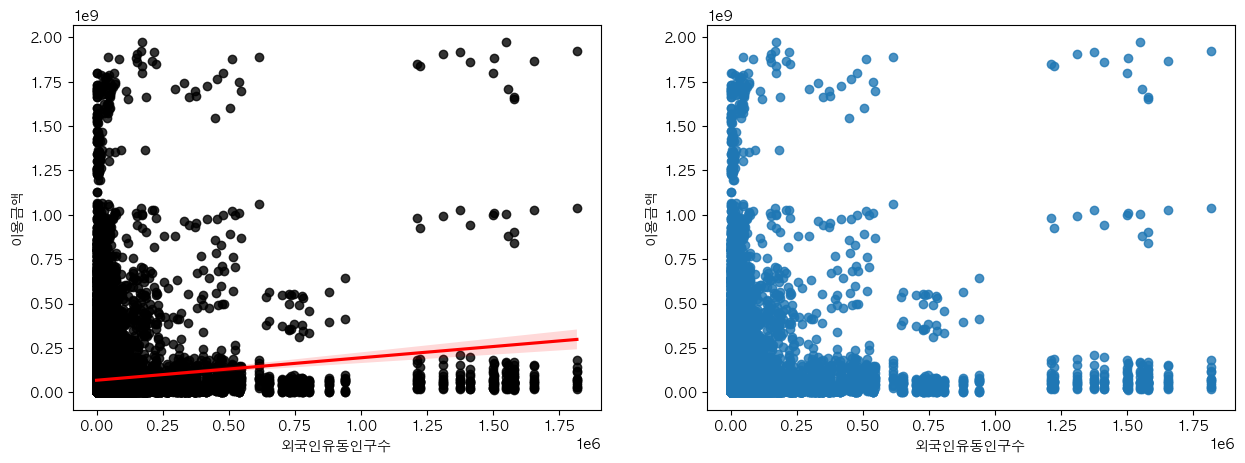

In [82]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# 1. 선형 회귀선
sns.regplot(
    x=sales_floating_foreigner_local_fit['외국인유동인구수'],
    y=sales_floating_foreigner_local_fit['이용금액'],
    data=sales_floating_foreigner_local_fit,
    scatter_kws={'color':'black'}, # scatter color
    line_kws={'color':'red'}, # regression line color
    # regression line 주변의 퍼져있는 부분은 표준오차 (신뢰구간)을 나타냄
    ax=ax1,
    fit_reg=True
)
sns.regplot(
    x=sales_floating_foreigner_local_fit['외국인유동인구수'],
    y=sales_floating_foreigner_local_fit['이용금액'],
    data=sales_floating_foreigner_local_fit,
    # scatter_kws={'color':'black'}, # scatter color
    # line_kws={'color':'red'}, # regression line color
    ax=ax2,
    fit_reg=False
)
plt.show()

In [83]:
month = sales_floating_foreigner_local_fit['년월'].str[5:8]
month = month.astype('int')

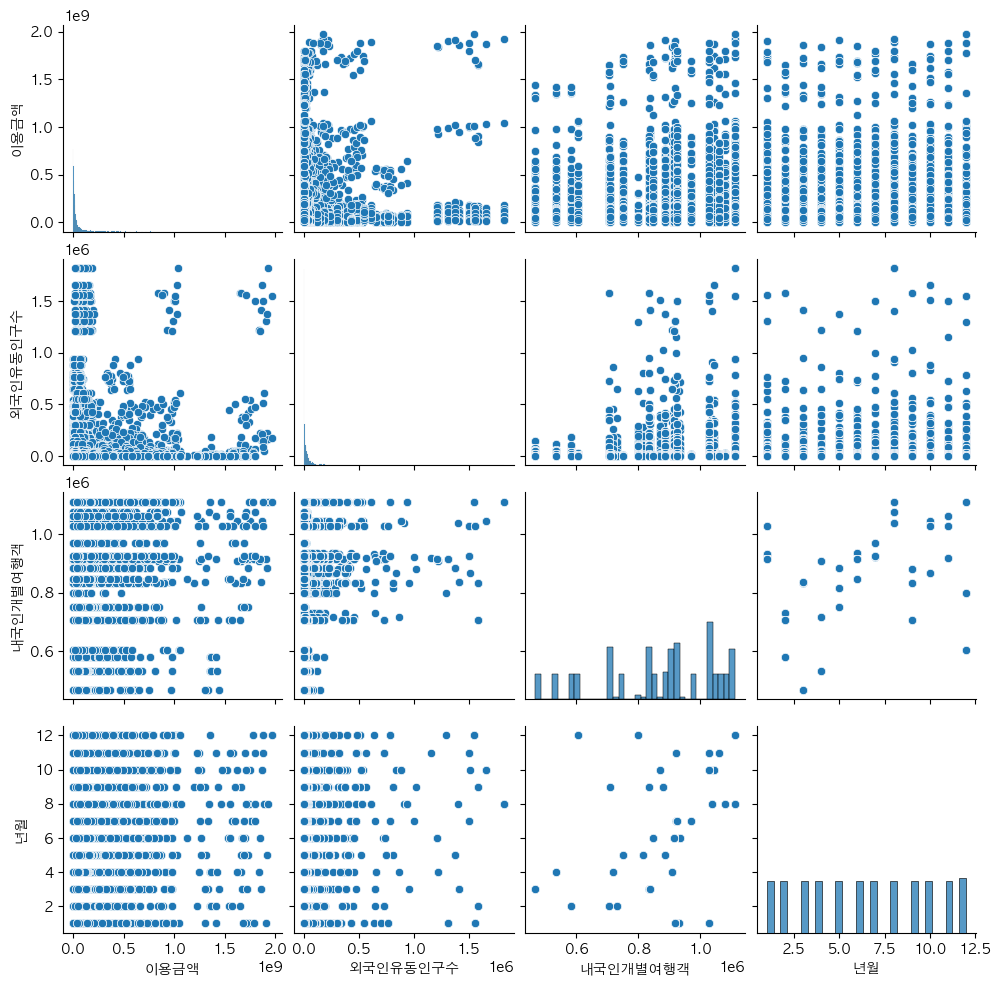

In [84]:
jeju_pair = sales_floating_foreigner_local_fit[['이용금액','외국인유동인구수','내국인개별여행객','년월']]
jeju_pair['년월'] = jeju_pair['년월'].str[5:8].astype('int')
sns.pairplot(
    jeju_pair
)
plt.ticklabel_format(axis='x',useOffset=True, style='plain')
plt.ticklabel_format(axis='y',useOffset=True, style='plain')
plt.show()

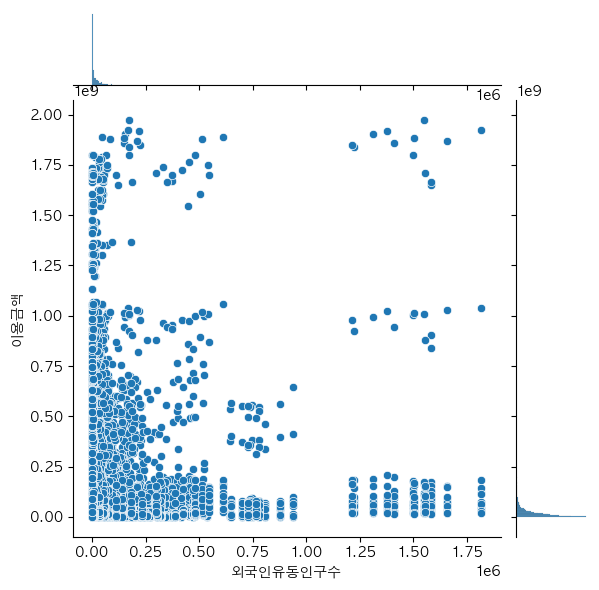

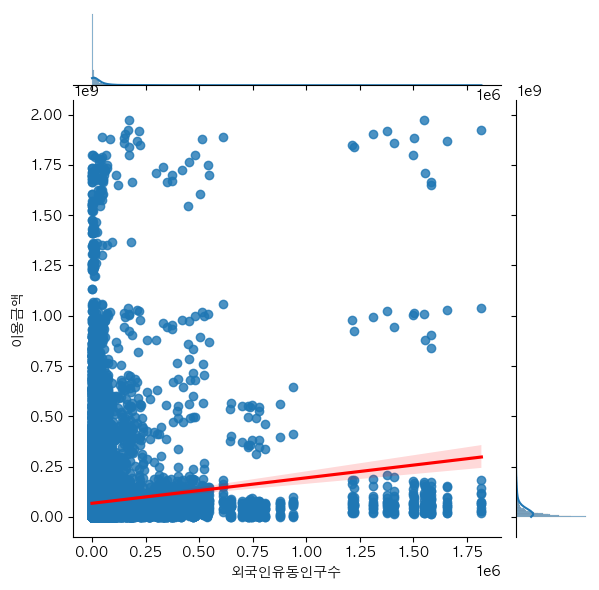

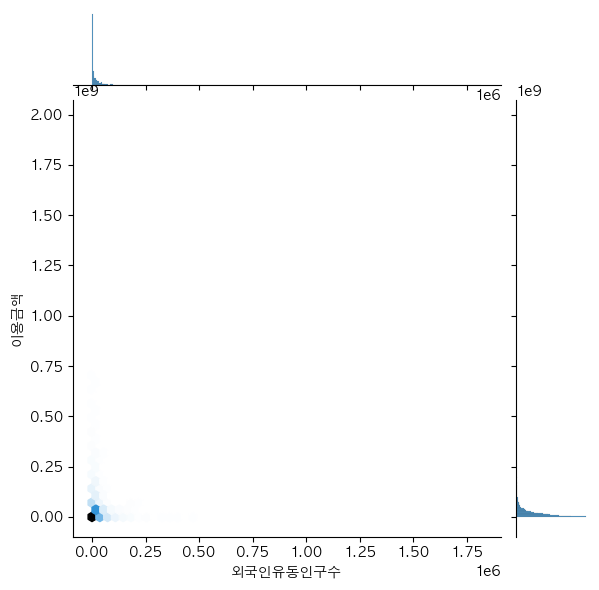

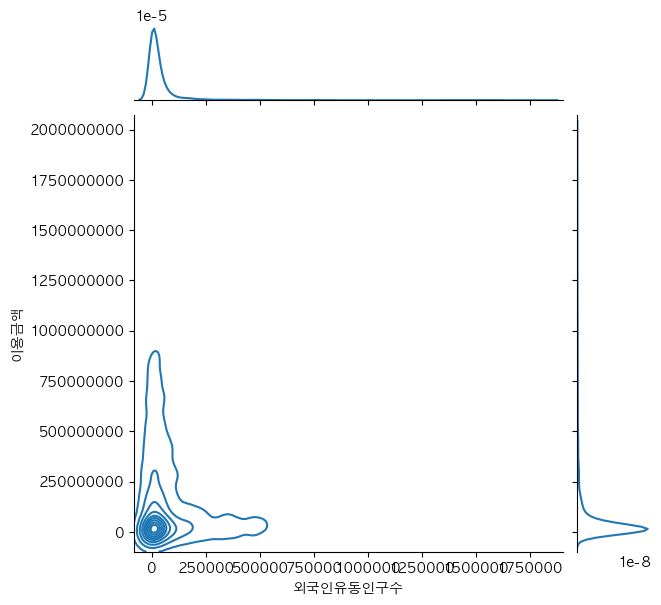

In [85]:
# 조인트 그래프 - 산점도
j1 = sns.jointplot(
    x='외국인유동인구수',
    y='이용금액',
    data=sales_floating_foreigner_local_fit,
    
)
# 조인트 그래프 - 회귀선
j2 = sns.jointplot(
    x='외국인유동인구수',
    y='이용금액',
    kind='reg',
    data=sales_floating_foreigner_local_fit,
    line_kws={'color':'red'}
    
)
# 조인트 그래프 - 육각그래프
j3 = sns.jointplot(
    x='외국인유동인구수',
    y='이용금액',
    kind='hex',
    data=sales_floating_foreigner_local_fit,
    
)
# 조인트 그래프 - 커널 밀집 그래프
j4 = sns.jointplot(
    x='외국인유동인구수',
    y='이용금액',
    kind='kde',
    data=sales_floating_foreigner_local_fit,
    
)
plt.ticklabel_format(axis='x',useOffset=True, style='plain')
plt.ticklabel_format(axis='y',useOffset=True, style='plain')
plt.show()

---
### 외국인 유동인구 수를 중국인, 중국 외 컬럼으로 변경

In [86]:
floating_foreigner_pop

,년월,시도명,읍면동명,국적,외국인유동인구수
0,2018-01,제주시,건입동,중국,30589.44000
0,2018-01,제주시,건입동,중국 외,32542.06000
1,2018-01,제주시,구좌읍,중국,26691.16000
1,2018-01,제주시,구좌읍,중국 외,14845.87000
2,2018-01,서귀포시,남원읍,중국,179846.03000
...,...,...,...,...,...
1545,2020-12,제주시,한림읍,중국 외,1349.65000
1546,2020-12,제주시,화북동,중국,35.49000
1546,2020-12,제주시,화북동,중국 외,338.90000
1547,2020-12,서귀포시,효돈동,중국,41.11000


In [87]:
fore = floating_foreigner_pop.copy()

In [88]:
df_chinese=fore[fore['국적']=='중국']
df_chinese.rename(columns={'외국인유동인구수':'중국인'},inplace=True)
df_chinese.drop(columns=['국적','시도명'],inplace=True)
df_chinese

,년월,읍면동명,중국인
0,2018-01,건입동,30589.44000
1,2018-01,구좌읍,26691.16000
2,2018-01,남원읍,179846.03000
3,2018-01,노형동,145583.19000
4,2018-01,대륜동,22743.85000
...,...,...,...
1543,2020-12,표선면,146.92000
1544,2020-12,한경면,41.86000
1545,2020-12,한림읍,331.76000
1546,2020-12,화북동,35.49000


In [89]:
df_other=fore[fore['국적']!='중국']
df_other.rename(columns={'외국인유동인구수':'중국 외'},inplace=True)
df_other.drop(columns=['국적','시도명'],inplace=True)
df_other

,년월,읍면동명,중국 외
0,2018-01,건입동,32542.06000
1,2018-01,구좌읍,14845.87000
2,2018-01,남원읍,22754.32000
3,2018-01,노형동,31173.26000
4,2018-01,대륜동,12868.88000
...,...,...,...
1543,2020-12,표선면,2106.80000
1544,2020-12,한경면,2378.70000
1545,2020-12,한림읍,1349.65000
1546,2020-12,화북동,338.90000


In [90]:
df_f=pd.merge(df_chinese,df_other,on=['년월','읍면동명'],how='inner')
df_f

,년월,읍면동명,중국인,중국 외
0,2018-01,건입동,30589.44000,32542.06000
1,2018-01,구좌읍,26691.16000,14845.87000
2,2018-01,남원읍,179846.03000,22754.32000
3,2018-01,노형동,145583.19000,31173.26000
4,2018-01,대륜동,22743.85000,12868.88000
...,...,...,...,...
1543,2020-12,표선면,146.92000,2106.80000
1544,2020-12,한경면,41.86000,2378.70000
1545,2020-12,한림읍,331.76000,1349.65000
1546,2020-12,화북동,35.49000,338.90000


In [91]:
df_sales = pd.read_csv("../JejuData/sales_floating_merged.csv")
df_sales

,년월,시도명,읍면동명,업종명,성별,이용자수,이용금액,거주인구,방문인구,국적,외국인유동인구수
0,2018-01,제주시,건입동,NaN,NaN,NaN,NaN,NaN,NaN,중국,30589.44000
1,2018-01,제주시,건입동,NaN,NaN,NaN,NaN,NaN,NaN,중국 외,32542.06000
2,2018-01,제주시,구좌읍,NaN,NaN,NaN,NaN,NaN,NaN,중국,26691.16000
3,2018-01,제주시,구좌읍,NaN,NaN,NaN,NaN,NaN,NaN,중국 외,14845.87000
4,2018-01,서귀포시,남원읍,NaN,NaN,NaN,NaN,NaN,NaN,중국,179846.03000
...,...,...,...,...,...,...,...,...,...,...,...
28695,2020-12,서귀포시,효돈동,한식 음식점업,여성,750.00000,22300000.00000,1447374.27000,553046.89000,중국 외,32.54000
28696,2020-12,서귀포시,효돈동,일식 음식점업,남성,102.00000,3799000.00000,1535266.85200,631567.06900,중국 외,32.54000
28697,2020-12,서귀포시,효돈동,일식 음식점업,여성,117.00000,3771000.00000,1447374.27000,553046.89000,중국 외,32.54000
28698,2020-12,서귀포시,효돈동,중식 음식점업,남성,391.00000,8687500.00000,1535266.85200,631567.06900,중국 외,32.54000


In [92]:
import sqlite3

In [93]:
sqlite3.sqlite_version

'3.40.0'

In [94]:
jeju_area = ['일도일동','일도이동','이도일동','이도이동','삼도일동','삼도이동','용담일동','용담이동','건입동','화북동','삼양동','봉개동','아라동','오라동','연동','노형동','외도동','이호동','도두동','한림읍','애월읍','한경면','조천읍','구좌읍','송산동','정방동','중앙동','천지동','효돈동','영천동','동홍동','서홍동','대륜동','대천동','중문동','예래동','대정읍','안덕면','남원읍','성산읍','표선면','추자면','우도면']
jeju_area

['일도일동',
 '일도이동',
 '이도일동',
 '이도이동',
 '삼도일동',
 '삼도이동',
 '용담일동',
 '용담이동',
 '건입동',
 '화북동',
 '삼양동',
 '봉개동',
 '아라동',
 '오라동',
 '연동',
 '노형동',
 '외도동',
 '이호동',
 '도두동',
 '한림읍',
 '애월읍',
 '한경면',
 '조천읍',
 '구좌읍',
 '송산동',
 '정방동',
 '중앙동',
 '천지동',
 '효돈동',
 '영천동',
 '동홍동',
 '서홍동',
 '대륜동',
 '대천동',
 '중문동',
 '예래동',
 '대정읍',
 '안덕면',
 '남원읍',
 '성산읍',
 '표선면',
 '추자면',
 '우도면']

In [95]:
len(jeju_area)

43

In [96]:
import pandas as pd

In [97]:
jeju_df = pd.DataFrame(jeju_area)

In [98]:
jeju_df.sort_values(by=0,ascending=True,inplace=True)

In [99]:
print(jeju_df.values.tolist())

[['건입동'], ['구좌읍'], ['남원읍'], ['노형동'], ['대륜동'], ['대정읍'], ['대천동'], ['도두동'], ['동홍동'], ['봉개동'], ['삼도이동'], ['삼도일동'], ['삼양동'], ['서홍동'], ['성산읍'], ['송산동'], ['아라동'], ['안덕면'], ['애월읍'], ['연동'], ['영천동'], ['예래동'], ['오라동'], ['외도동'], ['용담이동'], ['용담일동'], ['우도면'], ['이도이동'], ['이도일동'], ['이호동'], ['일도이동'], ['일도일동'], ['정방동'], ['조천읍'], ['중문동'], ['중앙동'], ['천지동'], ['추자면'], ['표선면'], ['한경면'], ['한림읍'], ['화북동'], ['효돈동']]
